# Exploratory Data Analysis

This project utilizes the [**Drowning Detection Dataset**](https://github.com/Wang-Kaikai/drowning-detection-dataset) sourced from the open-access repository provided by Yang et al.

This dataset was originally introduced in their research paper:
[**An Improved YOLOv5 Algorithm for Drowning Detection in the Indoor Swimming Pool**](https://doi.org/10.3390/app14010200)

The dataset consists of labeled images that represent various human states in aquatic environments, including:

- **Drowning**
- **Treading Water**
- **Swimming**

In this section, we aim to perform a thorough exploratory data analysis (EDA) to understand:

- The class distribution across different video segments.
- Sample visualizations for each behavior class.

This analysis serves as a foundation for designing robust detection and classification models in the later stages.


In [1]:
from dotenv import load_dotenv

load_dotenv()

import sys
import os

sys.path.append(os.getenv('SRC_DIR'))

from utils.system import display_system_info

display_system_info(markdown=True)


**Last Updated**: 2025-05-09 02:19:37

**Python Version**: 3.11.12  
**OS**: Windows 10.0.26100  
**Architecture**: 64bit  
**Hostname**: ShenLaptop  
**Processor**: Intel64 Family 6 Model 186 Stepping 3, GenuineIntel  
**RAM Size**: 15.65 GB  
  
        

In [2]:
import cv2

import matplotlib.pyplot as plt

from itertools import combinations
from collections import Counter
import re

CLASS_IDX_TO_NAME = {
    0: 'swimming',
    1: 'treadwater',
    2: 'drowning'
}

train_img_dir = os.path.join(os.getenv('RAW_DATA_DIR'), os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_labels_dir = os.path.join(os.getenv('RAW_DATA_DIR'), os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

cls_combinations = [frozenset(comb) for r in range(len(CLASS_IDX_TO_NAME.keys()) + 1) for comb in combinations(CLASS_IDX_TO_NAME.keys(), r)]


# Some utils function here
def read_ground_truth(path: str):
    with open(path, 'r') as f:
        cls_xywhn = []

        for line in f:
            values = line.strip().split(' ')

            cls = int(values[0])

            x_n, y_n, w_n, h_n = map(float, values[1:])

            cls_xywhn.append((cls, x_n, y_n, w_n, h_n))

        return cls_xywhn


def xywhn_to_xyxy(image, x_n, y_n, w_n, h_n):
    # cv2 images in HWC
    height, width, _ = image.shape

    x1 = int((x_n - w_n / 2) * width)
    y1 = int((y_n - h_n / 2) * height)
    x2 = int((x_n + w_n / 2) * width)
    y2 = int((y_n + h_n / 2) * height)

    return x1, y1, x2, y2


def get_filename_containing_classes(cls_combination: set, labels_dir: str) -> str:
    for filename in os.listdir(labels_dir):
        classes = [cls for cls, *_ in read_ground_truth(os.path.join(labels_dir, filename))]

        if set(classes) == cls_combination:
            return filename.split('.')[0]

    return None

According to the paper by [Wang KaiKai et al.](https://doi.org/10.3390/app14010200), the label numbers are corresponding to the class labels as follows:

| Label Number | Class Name  |
|--------------|-------------|
| 0            | Swimming    |
| 1            | Treading Water |
| 2            | Drowning    |

## Basic Dataset Understanding

Here the size of the datasets is shown

In [3]:
raw_data_img_dir = os.path.join(os.getenv('RAW_DATA_DIR'), os.getenv('IMG_DIR'))
raw_data_img_train_dir = os.path.join(raw_data_img_dir, os.getenv('TRAIN_DIR'))
raw_data_img_val_dir = os.path.join(raw_data_img_dir, os.getenv('val_DIR'))
            
train_img_count = len(os.listdir(raw_data_img_train_dir))
val_img_count = len(os.listdir(raw_data_img_val_dir))

print("%-30s: %d" % ("Number of training images", train_img_count))
print("%-30s: %d" % ("Number of validation images", val_img_count))
print("-" * 50)
print("%-30s: %d" % ("Total number of images", train_img_count + val_img_count))
print("-" * 50)

Number of training images     : 7000
Number of validation images   : 1572
--------------------------------------------------
Total number of images        : 8572
--------------------------------------------------


## Image Samples by Class Combinations

This section provides a visual overview of sample images extracted from the drowning detection dataset. Each image is annotated with bounding boxes indicating detected individuals, which correspond to different classes, that is *swimming*, *treading water*, and *drowning*.

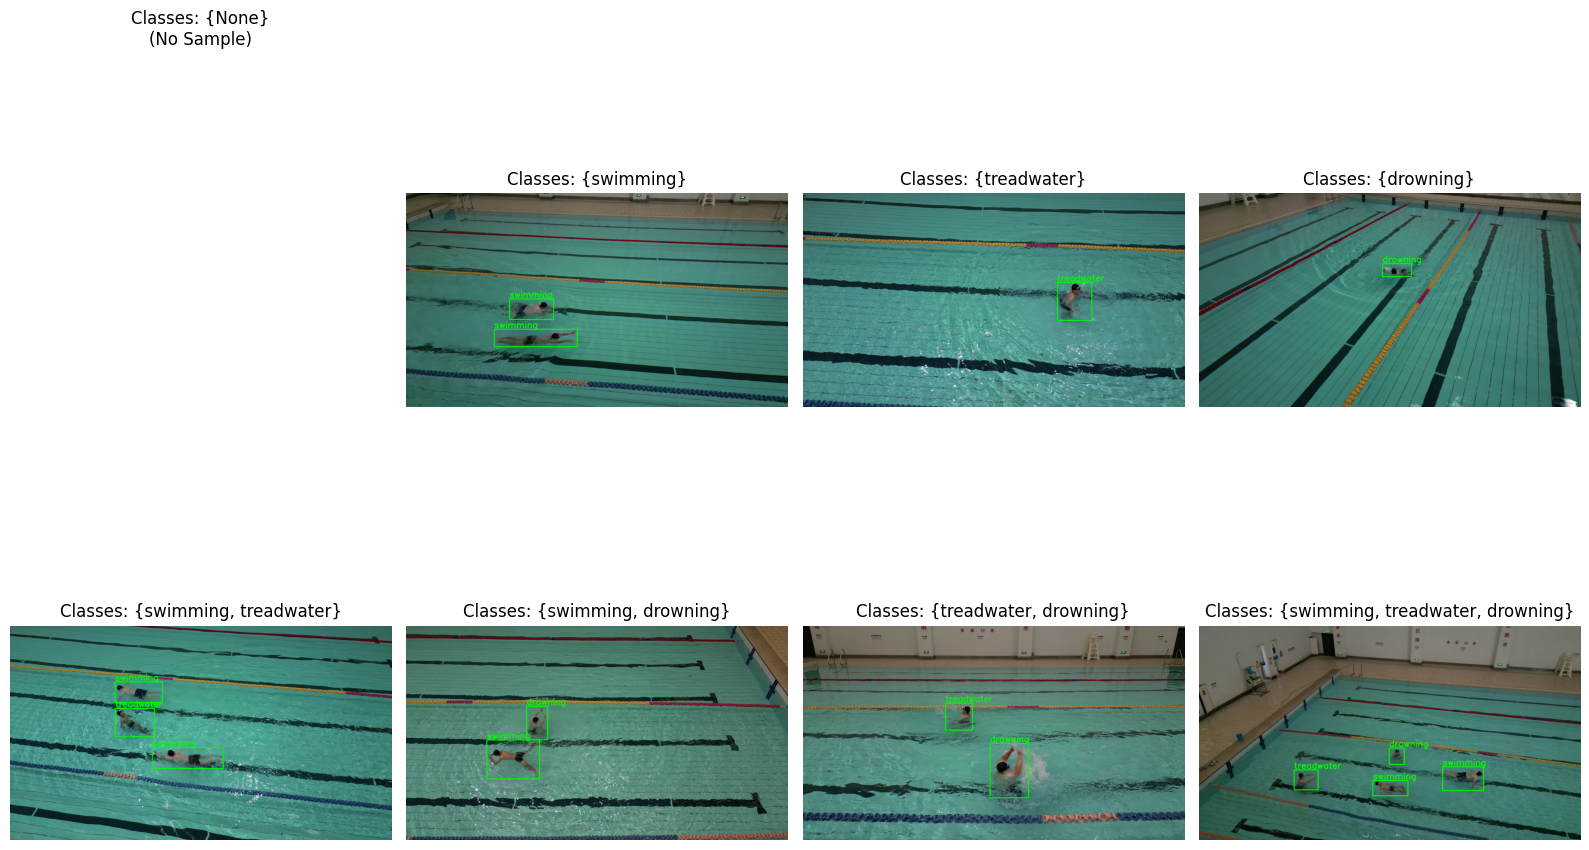

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, comb in enumerate(cls_combinations):
    filename = get_filename_containing_classes(comb, train_labels_dir) 

    axes[i].axis('off')
    
    if filename is None:
        axes[i].set_title('Classes: {%s}\n(No Sample)' % (", ".join([CLASS_IDX_TO_NAME[c] for c in comb]) if comb else 'None'))
        continue

    sample_img = cv2.imread(os.path.join(train_img_dir, filename + '.jpg'))
    cls_xywhns = read_ground_truth(os.path.join(train_labels_dir, f'{filename}.txt'))

    for cls, *xywhn in cls_xywhns:
        xyxy = xywhn_to_xyxy(sample_img, *xywhn)
        cv2.rectangle(sample_img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 5)
        cv2.putText(sample_img, f'{CLASS_IDX_TO_NAME[cls]}', (xyxy[0], xyxy[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)

    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    axes[i].imshow(sample_img)
    axes[i].set_title('Classes: {%s}' % (", ".join([CLASS_IDX_TO_NAME[c] for c in comb]) if comb else 'None'))

plt.tight_layout()
plt.show() 

## Distribution of Images by Class Combinations

Here the number of images in each class combinations is shown

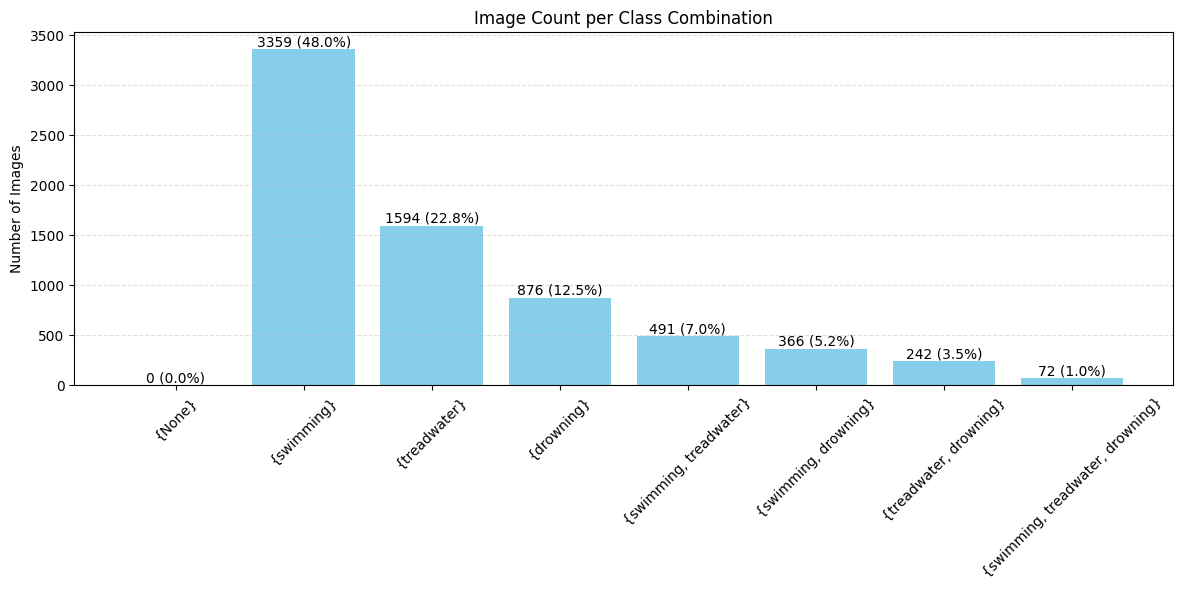

In [5]:
combination_counter = Counter()

for filename in os.listdir(train_labels_dir):
    label_path = os.path.join(train_labels_dir, filename)
    cls_ids = [cls for cls, *_ in read_ground_truth(label_path)]
    comb_key = frozenset(cls_ids)
    combination_counter[comb_key] += 1

for comb in cls_combinations:
    combination_counter.setdefault(comb, 0)

x_labels = ['{%s}' % (', '.join(CLASS_IDX_TO_NAME[c] for c in comb) if comb else 'None')
            for comb in cls_combinations]
counts = [combination_counter[comb] for comb in cls_combinations]

plt.figure(figsize=(12, 6))
bars = plt.bar(x_labels, counts, color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.title('Image Count per Class Combination')

total = sum(counts)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    percentage = (count / total * 100) if total > 0 else 0
    label = f'{count} ({percentage:.1f}%)'
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, label,
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Sample ROI for Classes

Here we display some sample cropped images for each class

Therefore, we can further confirm that the class labels are as follows:

| Label Number | Class Name  |
|--------------|-------------|
| 0            | Swimming    |
| 1            | Treading Water |
| 2            | Drowning    |

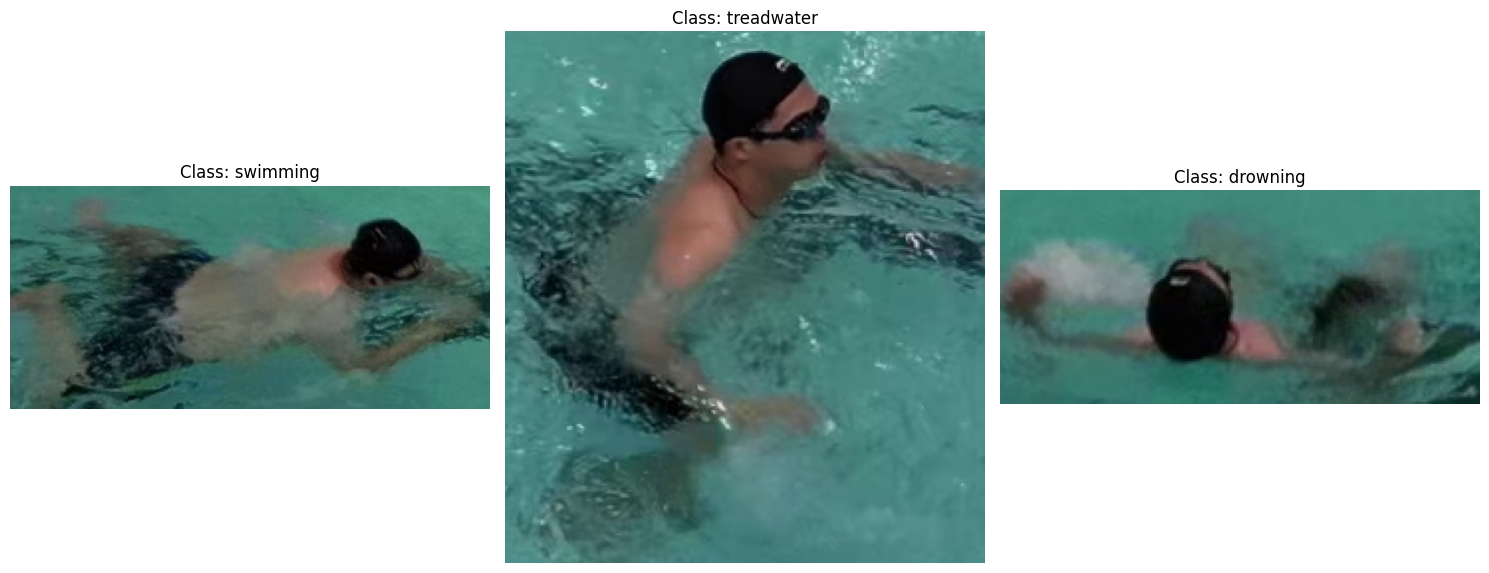

In [6]:
fig, axes = plt.subplots(1, len(CLASS_IDX_TO_NAME.keys()), figsize=(len(CLASS_IDX_TO_NAME.keys()) * 5, 6))

for i, cls_id in enumerate(CLASS_IDX_TO_NAME.keys()):
    filename = get_filename_containing_classes({cls_id}, train_labels_dir)

    axes[i].axis('off')

    if filename is None:
        axes[i].set_title('Class: %s\n(No Sample Found)' % CLASS_IDX_TO_NAME[cls_id])
        print(f'Class {CLASS_IDX_TO_NAME[cls_id]}: No sample found')
        continue
    
    sample_img = cv2.imread(os.path.join(train_img_dir, filename + '.jpg'))
    cls_xywhns = read_ground_truth(os.path.join(train_labels_dir, f'{filename}.txt'))

    _, *xywhn = cls_xywhns[0]
    xyxy = xywhn_to_xyxy(sample_img, *xywhn)

    sample_cls_roi = sample_img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
    sample_cls_roi = cv2.cvtColor(sample_cls_roi, cv2.COLOR_BGR2RGB)

    axes[i].imshow(sample_cls_roi)
    axes[i].set_title('Class: %s' % CLASS_IDX_TO_NAME[cls_id])

plt.tight_layout()
plt.show()

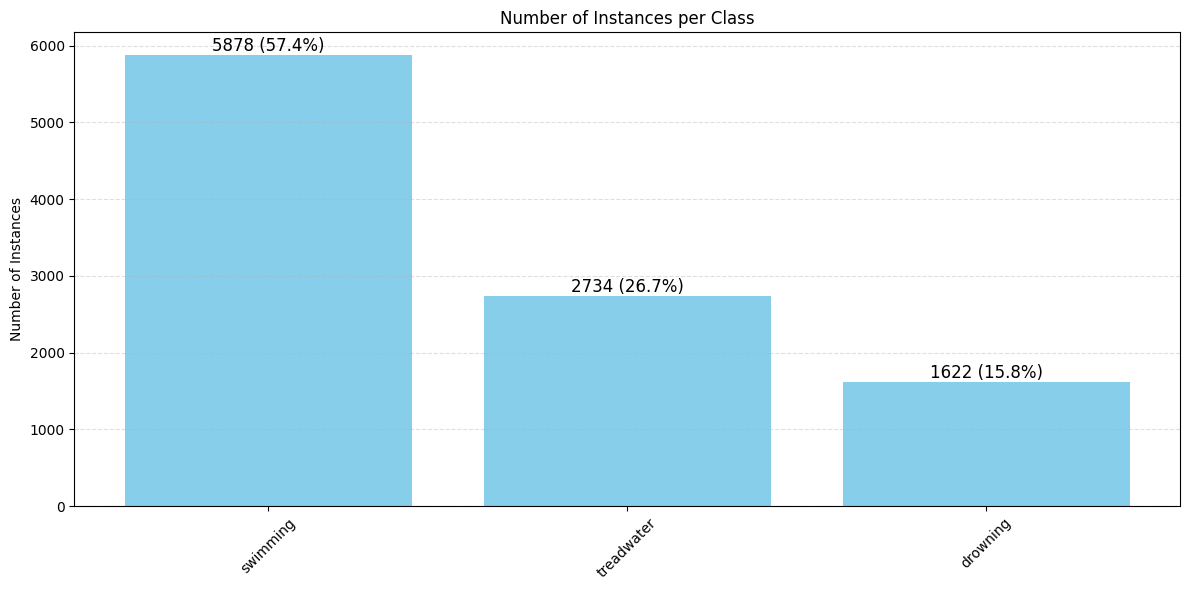

In [7]:
cls_counter = {
    key: 0 for key in CLASS_IDX_TO_NAME.keys()
}

for filename in os.listdir(train_labels_dir):
    label_path = os.path.join(train_labels_dir, filename)
    cls_ids = [cls_id for cls_id, *_ in read_ground_truth(label_path)]

    for cls_id in cls_ids:
        cls_counter[cls_id] += 1

x_labels = [CLASS_IDX_TO_NAME[cls_id] for cls_id in CLASS_IDX_TO_NAME.keys()]
counts = [cls_counter[cls_id] for cls_id in CLASS_IDX_TO_NAME.keys()]

plt.figure(figsize=(12, 6))
bars = plt.bar(x_labels, counts, color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.ylabel('Number of Instances')
plt.title('Number of Instances per Class')

total = sum(counts)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    percentage = (count / total * 100) if total > 0 else 0
    label = f'{count} ({percentage:.1f}%)'
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, label,
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## Understanding Image Channels

To better understand how different color representations impact image perception and feature extraction, we visualize the individual channel components across various color spaces:

- **RGB**: Red, Green, Blue  
- **HSV**: Hue, Saturation, Value  
- **LAB**: Lightness, Green–red (A), Blue–yellow (B)
- **YCbCr**: Luma (Y), Blue-difference chroma (Cb), Red-difference chroma (Cr)

By visualizing these channels independently, we can observe how each component contributes to the image, aiding in preprocessing and modelling tasks.


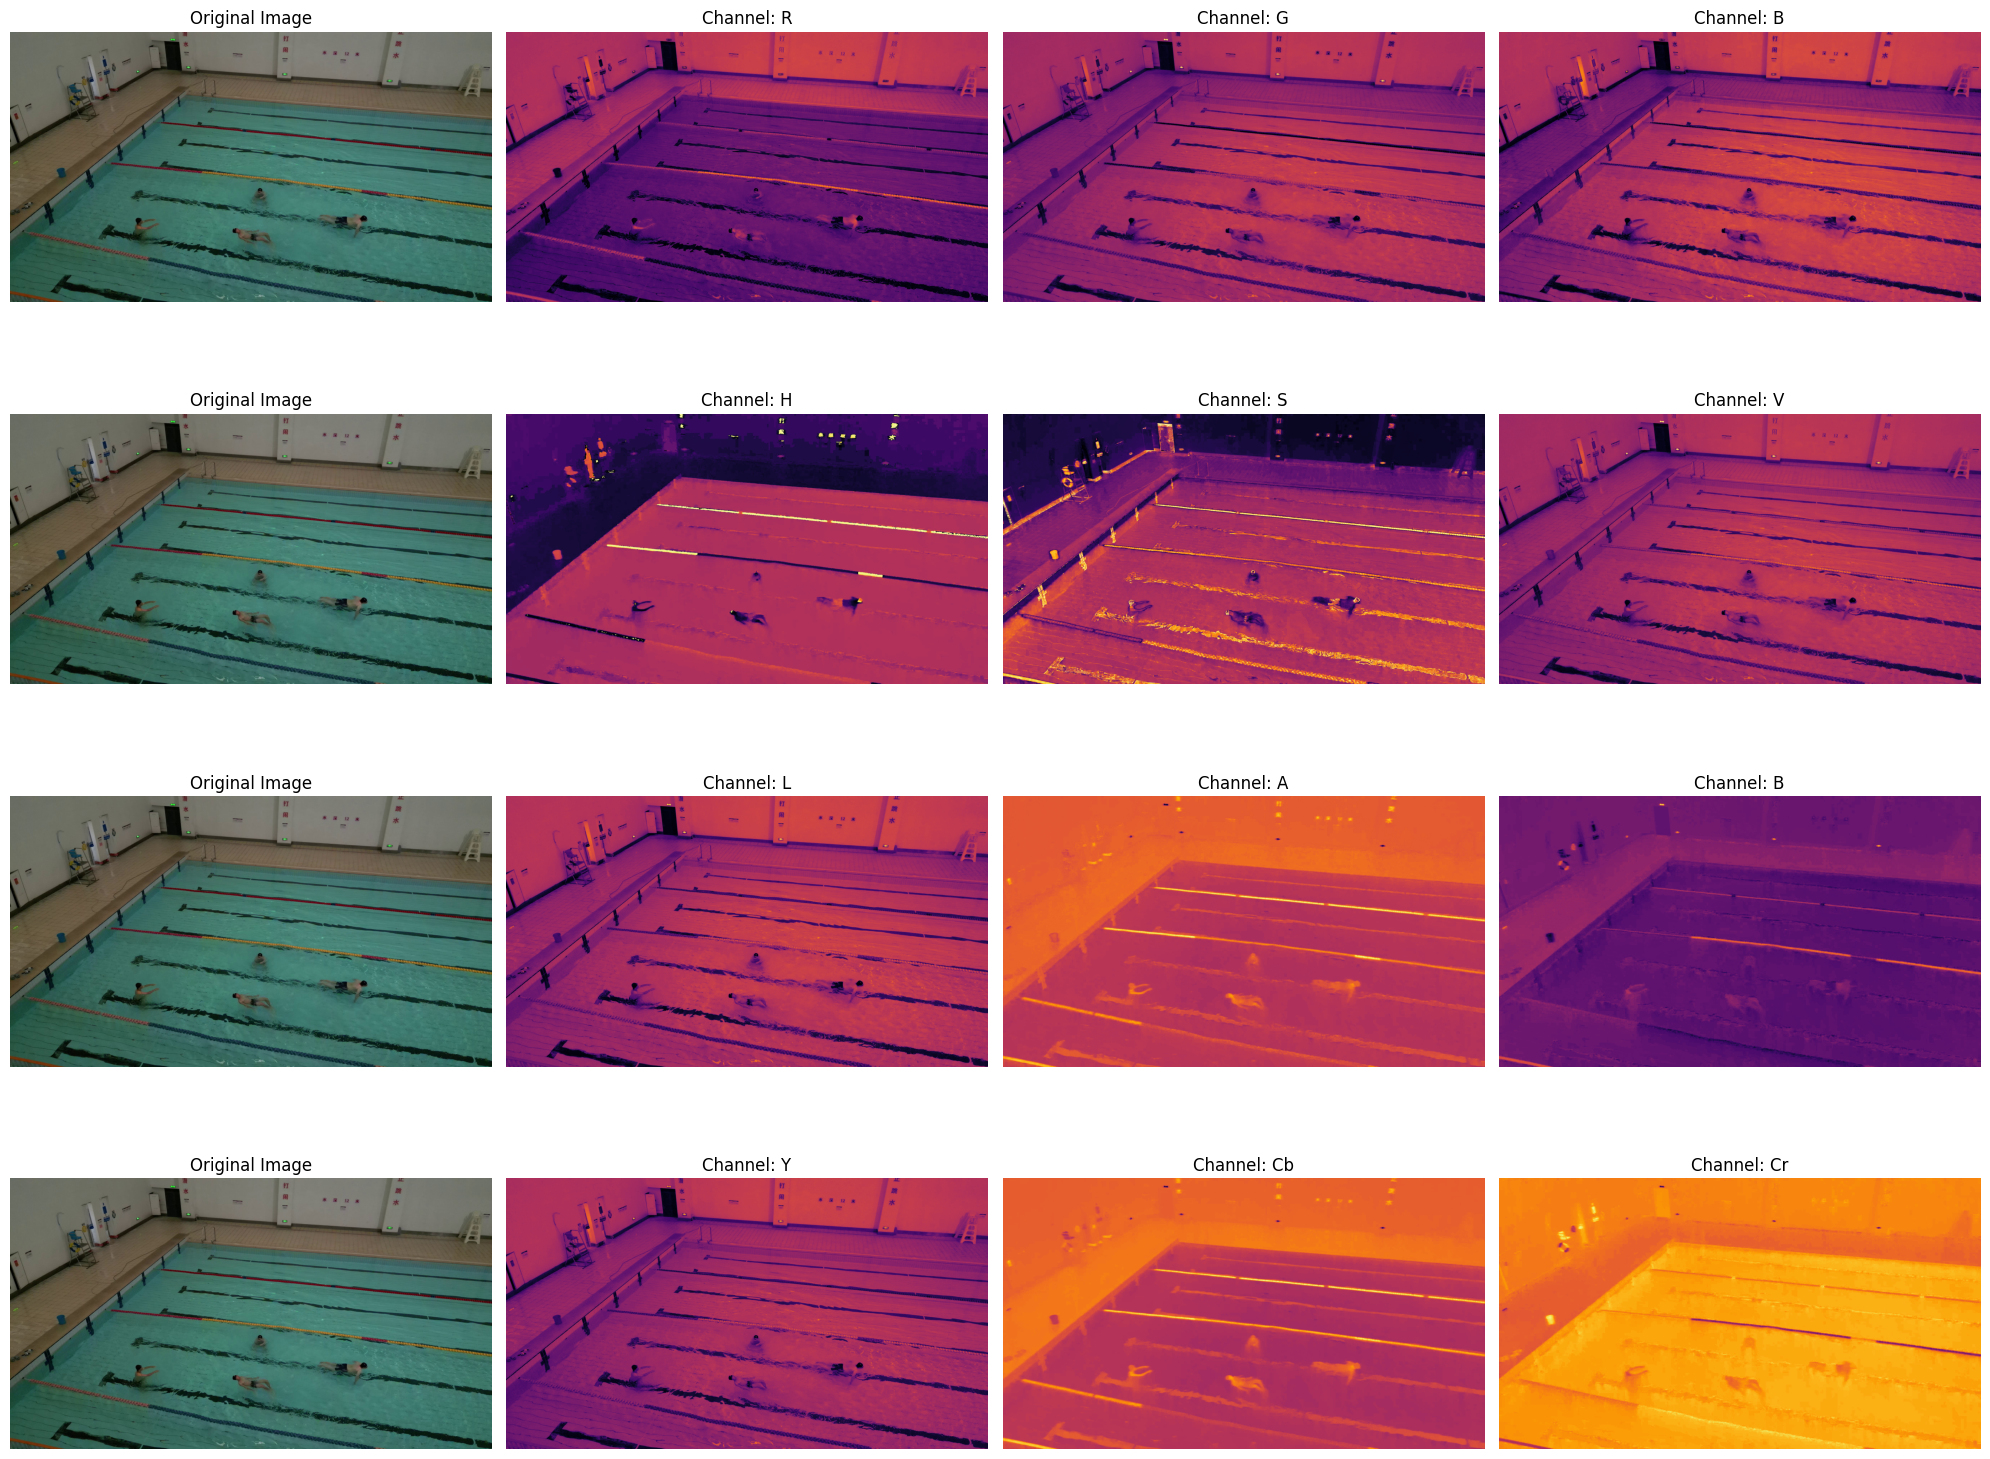

In [8]:
sample_filename = '000434'

sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))

COLOR_SPACES_MAPPING = {
    'RGB': cv2.COLOR_BGR2RGB,
    'HSV': cv2.COLOR_BGR2HSV,
    'LAB': cv2.COLOR_BGR2LAB,
    'YCbCr': cv2.COLOR_BGR2YCrCb
}

fig, axes = plt.subplots(4, len(COLOR_SPACES_MAPPING), figsize=(20, len(COLOR_SPACES_MAPPING) * 4))

format_imgs = []

for i, (color_space, cv_convert) in enumerate(COLOR_SPACES_MAPPING.items()):
    transformed_img = cv2.cvtColor(sample_img, cv_convert)

    channels = re.findall(r'[A-Z][a-z]*', color_space)

    axes[i][0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[i][0].set_title('Original Image', fontsize=12)
    axes[i][0].axis('off')

    for j, channel in enumerate(channels):
        axes[i][j + 1].imshow(transformed_img[:, :, j], cmap='inferno')
        axes[i][j + 1].set_title(f'Channel: {channel}', fontsize=12)
        axes[i][j + 1].axis('off')

plt.tight_layout()
plt.show()